In [9]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time
import numpy as np
import pickle
from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.time_series import *
from scripts.ra import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns

set_seed(313)
save_dir = 'experiments/all_targets'

# 2D systems

# Limit cycles

### Van der Pol oscillator

#### Deterministic VdP

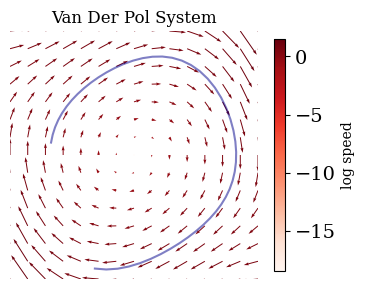

In [18]:
# generate trajectories for Van der Pol target system
set_seed(313)

system_name = 'vdp'
simulation_params = {
    'system': 'vdp',  # Target system name
    'dim': 2,
    'mu': 0.3,  # Van der Pol parameter
    'maxT': 5.0,  # Time span for simulation
    'num_points': 50,  # Number of points in the trajectory
    'dt': 0.1,  # Time step size
    'noise_std': 0.0,  # Noise level for the simulation
    'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-2.0, 2.0)]*2,  # Bounds for sampling
    'noise_std': 0.0,  # Noise level for the simulation
}
vdp_system = VanDerPol(mu=simulation_params['mu'])
time_span = torch.tensor([0.0, simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method=simulation_params['sampling_method'],         # Specifies the density-based sampling method
    noise_std=simulation_params['noise_std'],                     # Specifies the noise level for the simulation
    init_points_bounds=simulation_params['bounds'],                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)
X, Y, U, V = get_ds_vf(vdp_system, bounds=[-2.0, 2.0], num_points=15)
plot_vector_field_coloredquivernorm(
    X, Y, U, V, trajectories_target[0].unsqueeze(dim=0), title='Van Der Pol System',
    background_color='white', cmap='Reds', traj_color='darkblue', alpha=0.5,
    #save_name=save_dir + '/vdp_vector_field.png',
    min_val_plot=2, #vmin_log=-6, vmax_log=4, 
)

np.save(f"{save_dir}/{system_name}_trajectories_target.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(simulation_params, f)

#### Noisy VdP

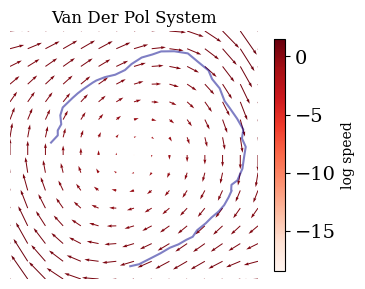

In [19]:
# generate trajectories for Noisy Van der Pol target system
set_seed(313)

system_name = 'noisy_vdp'
vdp_simulation_params = {
    'system': 'vdp',  # Target system name
    'dim': 2,
    'mu': 0.3,  # Van der Pol parameter
    'maxT': 5.0,  # Time span for simulation
    'num_points': 50,  # Number of points in the trajectory
    'dt': 0.1,  # Time step size
    'noise_std': 0.75,  # Noise level for the simulation
    'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-2.0, 2.0)]*2,  # Bounds for sampling
}
vdp_system = VanDerPol(mu=vdp_simulation_params['mu'], noise_std=vdp_simulation_params['noise_std'])
time_span = torch.tensor([0.0, vdp_simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method=vdp_simulation_params['sampling_method'],         # Specifies the density-based sampling method
    noise_std=vdp_simulation_params['noise_std'],                     # Specifies the noise level for the simulation
    init_points_bounds=vdp_simulation_params['bounds'],                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=vdp_simulation_params['dt'], num_points=vdp_simulation_params['num_points'],                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)
X, Y, U, V = get_ds_vf(vdp_system, bounds=[-2.0, 2.0], num_points=15)
plot_vector_field_coloredquivernorm(
    X, Y, U, V, trajectories_target[0].unsqueeze(dim=0), title='Van Der Pol System',
    background_color='white', cmap='Reds', traj_color='darkblue', alpha=0.5,
    #save_name=save_dir + '/vdp_vector_field.png',
    min_val_plot=2, #vmin_log=-6, vmax_log=4, 
)

np.save(f"{save_dir}/{system_name}_trajectories_target.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(vdp_simulation_params, f)

## Selkov

In [ ]:
# generate trajectories for Van der Pol target system
set_seed(313)

system_name = 'selkov'
simulation_params = {
    'system': 'vdp',  # Target system name
    'dim': 2,
    'mu': 0.3,  # Van der Pol parameter
    'maxT': 5.0,  # Time span for simulation
    'num_points': 50,  # Number of points in the trajectory
    'dt': 0.1,  # Time step size
    'noise_std': 0.0,  # Noise level for the simulation
    'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-2.0, 2.0)]*2,  # Bounds for sampling
    'noise_std': 0.0,  # Noise level for the simulation
}
vdp_system = Selkov(mu=simulation_params['mu'])
time_span = torch.tensor([0.0, simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method=simulation_params['sampling_method'],         # Specifies the density-based sampling method
    noise_std=simulation_params['noise_std'],                     # Specifies the noise level for the simulation
    init_points_bounds=simulation_params['bounds'],                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)
X, Y, U, V = get_ds_vf(vdp_system, bounds=[-2.0, 2.0], num_points=15)
plot_vector_field_coloredquivernorm(
    X, Y, U, V, trajectories_target[0].unsqueeze(dim=0), title='Van Der Pol System',
    background_color='white', cmap='Reds', traj_color='darkblue', alpha=0.5,
    #save_name=save_dir + '/vdp_vector_field.png',
    min_val_plot=2, #vmin_log=-6, vmax_log=4, 
)

np.save(f"{save_dir}/{system_name}_trajectories_target.npy", trajectories_target.detach().numpy())
with open(f"{save_dir}/{system_name}_simulation_params.pkl", "wb") as f:
    pickle.dump(simulation_params, f)

In [1]:
# import torch
# import matplotlib.pyplot as plt

# class HodgkinHuxley:
#     def __init__(self, dt=0.001):
#         self.dt = dt
#         self.C_m = 1.0
#         self.g_Na = 120.0
#         self.g_K = 36.0
#         self.g_L = 0.3
#         self.E_Na = 50.0
#         self.E_K = -77.0
#         self.E_L = -54.387

#     def alpha_m(self, V):
#         return 0.1 * (25.0 - V) / (torch.exp((25.0 - V) / 10.0) - 1.0 + 1e-9)

#     def beta_m(self, V):
#         return 4.0 * torch.exp(-V / 18.0)

#     def alpha_h(self, V):
#         return 0.07 * torch.exp(-V / 20.0)

#     def beta_h(self, V):
#         return 1.0 / (torch.exp((30.0 - V) / 10.0) + 1.0)

#     def alpha_n(self, V):
#         return 0.01 * (10.0 - V) / (torch.exp((10.0 - V) / 10.0) - 1.0 + 1e-9)

#     def beta_n(self, V):
#         return 0.125 * torch.exp(-V / 80.0)

#     def I_ext(self, t):
#         return 10.0 if 10.0 < t < 40.0 else 0.0

#     def dxdt(self, t, x):
#         V, m, h, n = x
#         I_Na = self.g_Na * m**3 * h * (V - self.E_Na)
#         I_K = self.g_K * n**4 * (V - self.E_K)
#         I_L = self.g_L * (V - self.E_L)
#         I = self.I_ext(t)

#         dVdt = (I - I_Na - I_K - I_L) / self.C_m
#         dmdt = self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
#         dhdt = self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
#         dndt = self.alpha_n(V) * (1 - n) - self.beta_n(V) * n

#         return torch.tensor([dVdt, dmdt, dhdt, dndt])

#     def rk4_step(self, t, x):
#         dt = self.dt
#         k1 = self.dxdt(t, x)
#         k2 = self.dxdt(t + dt / 2, x + dt * k1 / 2)
#         k3 = self.dxdt(t + dt / 2, x + dt * k2 / 2)
#         k4 = self.dxdt(t + dt, x + dt * k3)
#         return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

# # --- Simulation setup ---
# hh = HodgkinHuxley(dt=0.001)
# T = 4*50.0  # ms
# steps = int(T / hh.dt)
# t_vals = torch.linspace(0, T, steps)

# # Initial conditions: resting state
# x = torch.tensor([-65.0, 0.0529, 0.596, 0.3177])
# trajectory = torch.zeros(steps, 4)
# trajectory[0] = x

# # Integrate
# for i in range(1, steps):
#     t = t_vals[i-1].item()
#     x = hh.rk4_step(t, x)
#     trajectory[i] = x

# # Plot membrane voltage
# plt.figure(figsize=(10, 4))
# plt.plot(t_vals.numpy(), trajectory[:, 0].numpy())
# plt.title("Hodgkin-Huxley Action Potentials")
# plt.xlabel("Time (ms)")
# plt.ylabel("Membrane Potential (mV)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


## Ring attractors

In [21]:
dim=2
dt = .2
noise_std = 0.0
time_span = torch.tensor([0.0, 2.])
analytic = True
vf_on_ring_enabled = True
training_pairs = False
alpha_init = None
ds_params = {'ds_motif': 'ring', 'dim': dim, 'dt': dt, 'time_span': time_span,'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
simulation_params = {'initial_conditions_mode': 'random','number_of_target_trajectories': 50,'time_span': time_span,'dt': dt,'noise_std': 0.0,'training_pairs': training_pairs,'margin': 0.5,'seed': 42,'ds_params': ds_params}
generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=noise_std)
generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=noise_std)
init_conds = prepare_initial_conditions(
    mode=simulation_params['initial_conditions_mode'],
    num_points=simulation_params['number_of_target_trajectories'],
    margin=simulation_params['margin'],
    seed=simulation_params['seed']
)
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
ra_trajs = ra_trajs.detach().numpy()
np.save(f"{save_dir}/ra_trajectories_target.npy", ra_trajs)

### Homeomorphism-perturbed

### Vector field-perturbed

In [151]:
dim = 2
maxT = 5
tsteps = maxT*20
max_perturbation_norm = .15
pring_simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01, "random_seed": 313, "min_val_sim": 3, "n_grid": 40, "add_limit_cycle": False, "num_points_invman": 20,
                            "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.25}

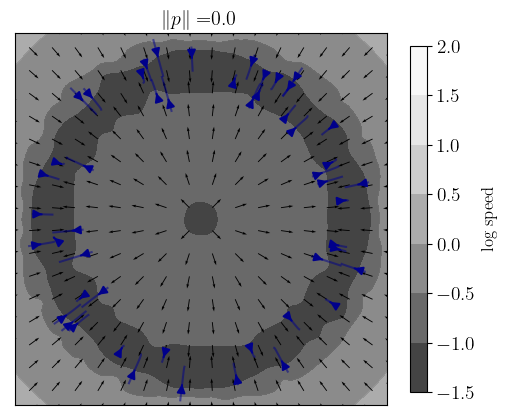

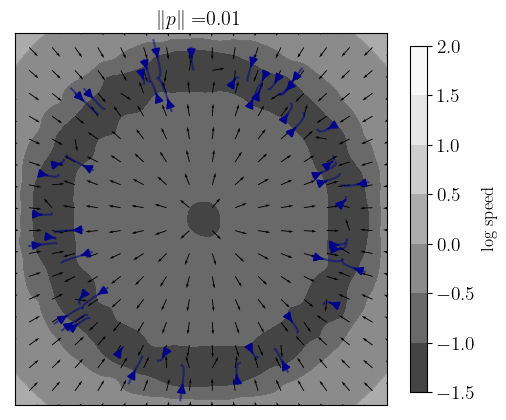

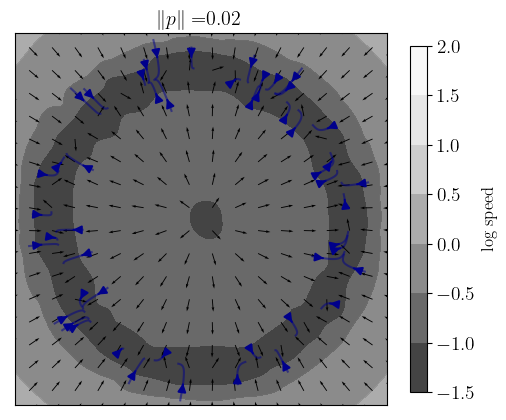

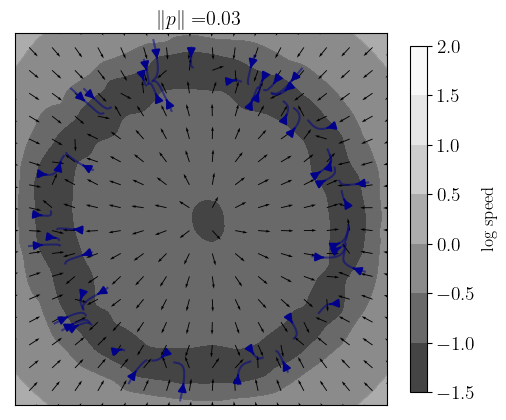

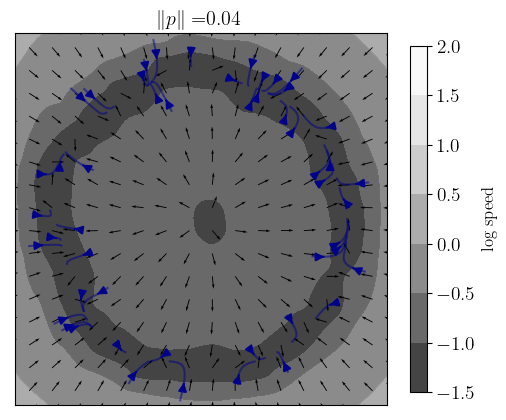

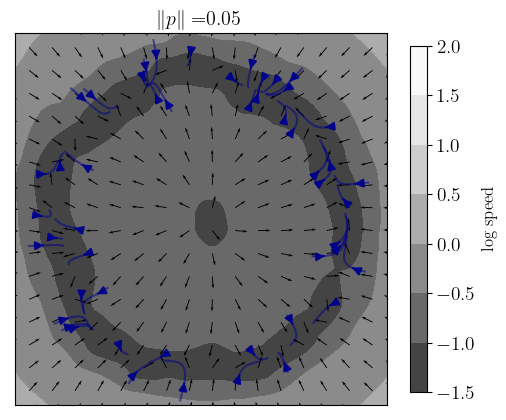

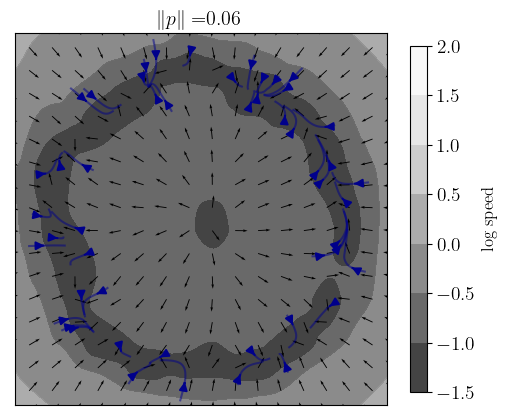

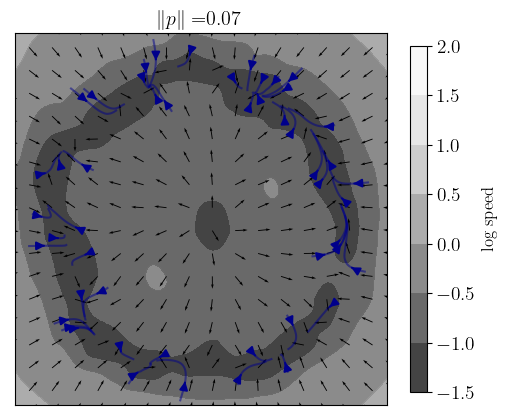

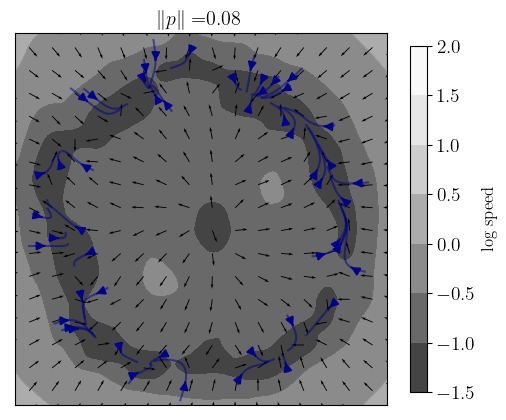

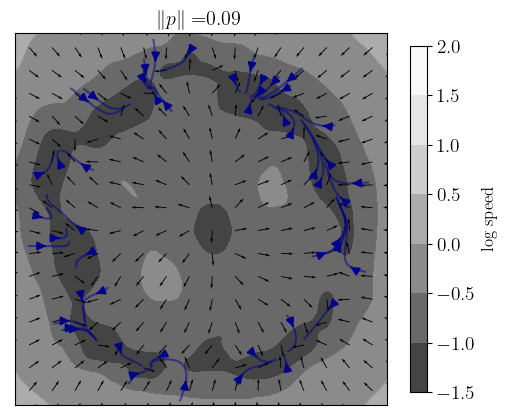

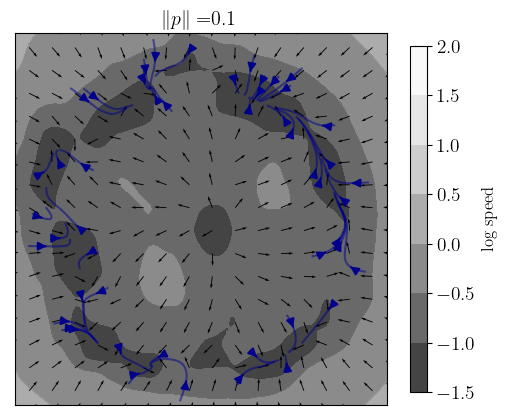

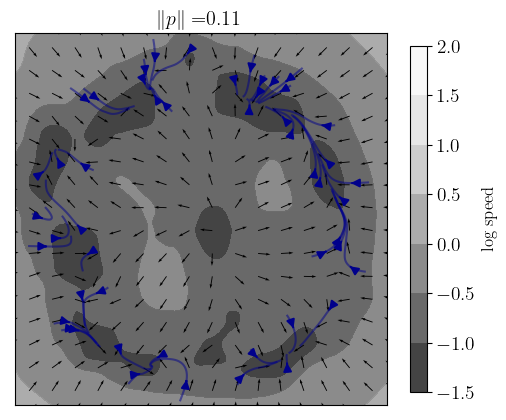

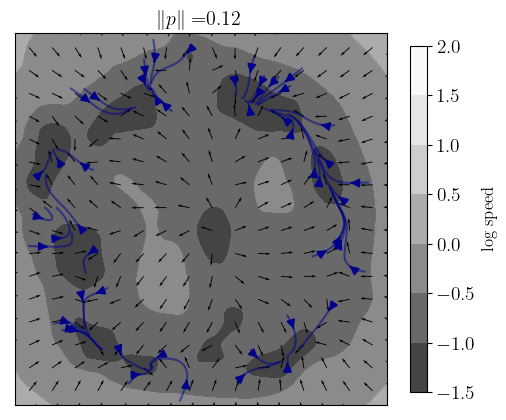

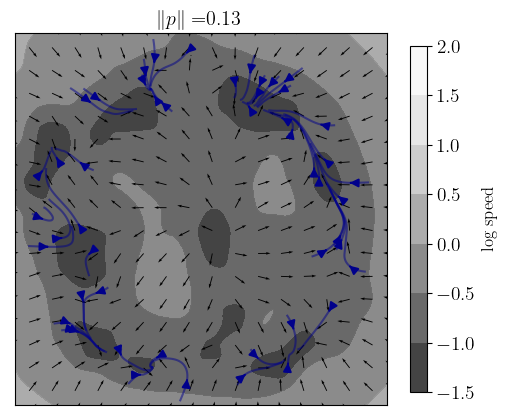

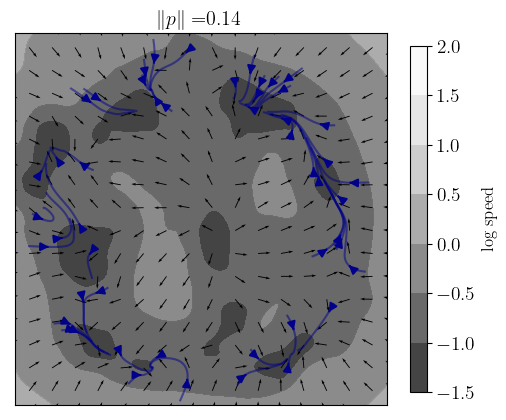

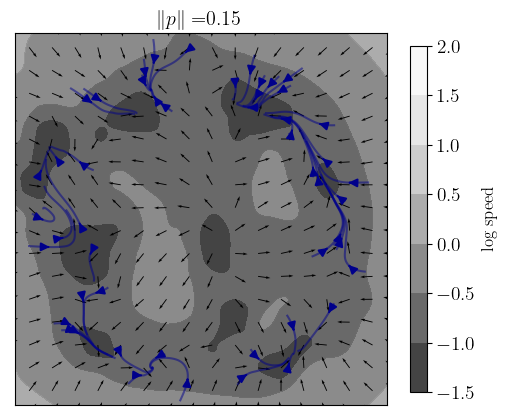

In [ ]:
# Plot the trajectories and vector field
save_dir = 'experiments/vf_pert_ring/vfs/'
for p_norm in np.arange(0.0, max_perturbation_norm + 0.001, 0.01):
    pring_simulation_params['perturbation_norm'] = p_norm
    X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 
    # U = X * (1- np.sqrt(X**2 + Y**2))
    # V = Y * (1- np.sqrt(X**2 + Y**2))
    # plot_vector_field_fixedquivernorm_speedcontour(X, Y, U_pert, V_pert, trajectories_pertring, title=f"$\|p\|=${p_norm}", scale=1.0, color='teal', alpha=0.5, cmap='Greys_r', traj_color='darkblue', background_color='white', min_val_plot=1.25,
    #                                             vmin_log=-1.5, vmax_log=2, level_step=.5,
    #                                             save_name=f"{save_dir}/vf_pring_{p_norm}.pdf")
#plot_vector_field_coloredquivernorm(X, Y, U_pert-U, V_pert-V, trajectories_pertring,  scale=10, title=f"$\|{p_norm}\|$", traj_color='darkblue', cmap='inferno') #, save_name=f"{save_dir}/vf_{p_norm}.pdf")

### Noisy ring (+perturbations?)

In [22]:
noise_std = 0.25
generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=noise_std)
init_conds = prepare_initial_conditions(
    mode=simulation_params['initial_conditions_mode'],
    num_points=simulation_params['number_of_target_trajectories'],
    margin=simulation_params['margin'],
    seed=simulation_params['seed']
)
ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))
ra_trajs = ra_trajs.detach().numpy()
np.save(f"{save_dir}/ra_trajectories_target_nstd{noise_std}.npy", ra_trajs)

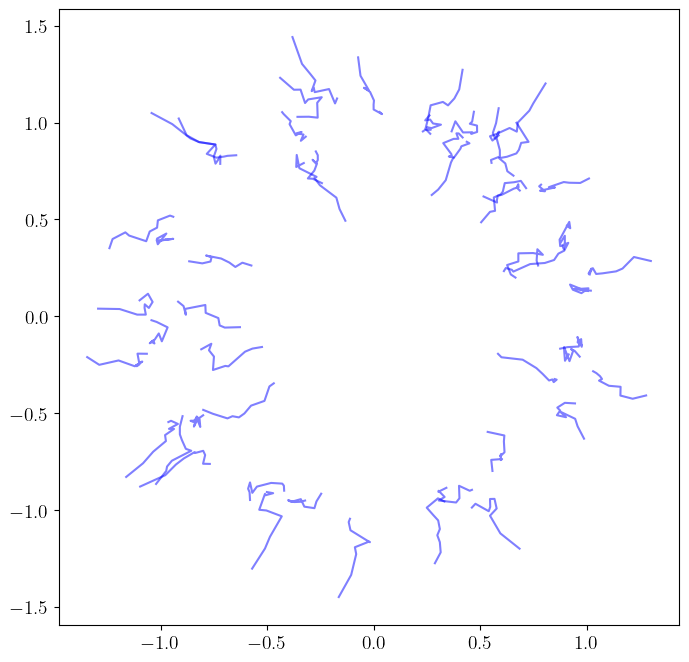

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ra_trajs[:, :, 0].T, ra_trajs[:, :, 1].T, '-', markersize=2, color='blue', alpha=0.5);